<a href="https://colab.research.google.com/github/DarKenW/customer-driven-data-science/blob/main/Customer_Analytics_Purchase_Analytics_Predictive_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
import numpy as np
import pandas as pd

# We import the sk learn modules we'll need to segment our new data. We'll need scaler, pca and k-means.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# We import pickle in order to be able to load our pickled objects.
import pickle
# We import the Logistic Regression module from sk learn for the purchase probability model.
from sklearn.linear_model import LogisticRegression 
#We import the necessary libraries for visualization. We set seaborn do be our default.
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()
# We import the Linear Regression module from sk learn for the quantity model.
from sklearn.linear_model import LinearRegression

## Data Preparation

In [4]:
# df_purchase = pd.read_csv('purchase data.csv')

from google.colab import drive
drive.mount('/content/drive')

# Load the data, contained in the segmentation data csv file.
GD_PATH = '/content/drive/MyDrive/扬FAANG起航/单项准备/customer analytics/'
df_purchase = pd.read_csv(GD_PATH+'purchase data.csv', index_col = 0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#load data
df_purchase = pd.read_csv(GD_PATH+'purchase data.csv')

# Import Scaler
scaler = pickle.load(open(GD_PATH+'scaler.pickle', 'rb'))
# Import PCA
pca = pickle.load(open(GD_PATH+'pca.pickle', 'rb'))
# Import K-Means
kmeans_pca = pickle.load(open(GD_PATH+'kmeans_pca.pickle', 'rb'))
# Standardization
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_purchase_segm_std = scaler.transform(features)
# Apply PCA
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)
# Segment data
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

# Create a copy of the data frame
df_purchase_predictors = df_purchase.copy()
# Add segment labels
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

df_pa = df_purchase_predictors

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported fr

## Purchase Probability Model

In [7]:
# In order to predict we need input and output variables. 
# Our Y is Incidence, as we want to predict the purchase probability for our customers
Y = df_pa['Incidence']

In [8]:
# Our dependant variable is based on the average price of chocolate candy bars. 
# Therefore, X is a data frame, containing the mean across the five prices.
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5'] ) / 5

In [9]:
# We create a Logistic Regression model using sk learn. Then we fit the model with our X or price and our Y or incidence.
model_purchase = LogisticRegression(solver = 'sag')
model_purchase.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
# The coefficients for price. It is negative, signaling that with an increase in price, the purchase probability decreases.
model_purchase.coef_

array([[-2.34842615]])

## Price Elasticity of Purchase Probability

In [11]:
# Here we see the prices for the five different brands, which is an important factor in determining purchase probability. 
# It informs the price range, for which we will be exploring purchase probability.
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [12]:
# We introduce the price range for which we'll examine the purchase probability.
# We choose a price range between 0.5 and 3.49, which somewhat expands the actual observed price range, 
# which is from 1.1 to 2.8. 
price_range = np.arange(0.5, 3.5, 0.01)
price_range

array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
       0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
       0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
       0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04,
       1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15,
       1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26,
       1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37,
       1.38, 1.39, 1.4 , 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48,
       1.49, 1.5 , 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59,
       1.6 , 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 ,
       1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81,
       1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92,
       1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.

In [13]:
df_price_range = pd.DataFrame(price_range)

In [14]:
# We predict the purchase probability for our newly defined price range. 
# The result is a 2x300  array. The first column shows the probability for not purchasing the product, 
# the second the probability for purchase for each price point in our price range.
Y_pr = model_purchase.predict_proba(df_price_range)
purchase_pr = Y_pr[:][:, 1]
pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)

In [15]:
# Create price elasticities master data frame.
# It will contain all the elasticities we calculate during the purchase analytics part of the course.
df_price_elasticities = pd.DataFrame(price_range)

In [16]:
df_price_elasticities = df_price_elasticities.rename(columns = {0: "Price_Point"})
df_price_elasticities['Mean_PE'] = pe
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096468
1,0.51,-0.100539
2,0.52,-0.104737
3,0.53,-0.109066
4,0.54,-0.113528
...,...,...
295,3.45,-8.014316
296,3.46,-8.039567
297,3.47,-8.064783
298,3.48,-8.089966


In [17]:
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096468
1,0.51,-0.100539
2,0.52,-0.104737
3,0.53,-0.109066
4,0.54,-0.113528
5,0.55,-0.118127
6,0.56,-0.122865
7,0.57,-0.127747
8,0.58,-0.132776
9,0.59,-0.137955


Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

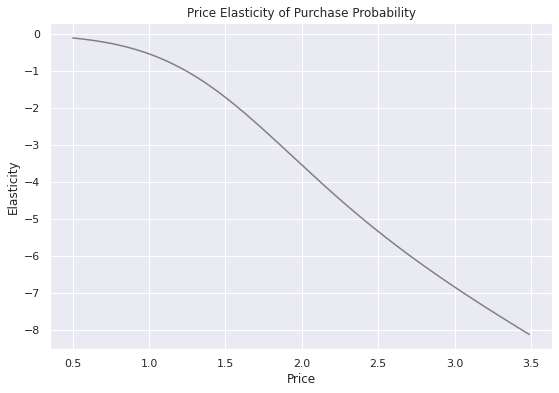

In [18]:
# We display the price elasticity of purchase probability of the average customer.
# We observe that the price elasticities are all negative. Furthermore we can spot where the customer becomes inelastic.
# But to find the precise spot we can consult the price elasticities data frame.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

## Purchase Probability by Segments

### $\color{green}{\text{Segment 1 - Career-Focused}}$

In [19]:
# We filter the data to contain only customers from segment 1, the career-focused.
df_pa_segment_1 = df_pa[df_pa['Segment'] == 1]

In [20]:
# Again we want to predict the purchase probability, so our Y variable is the incidence column.
# Only here we select only the customers from the first segment.
Y = df_pa_segment_1['Incidence']

In [21]:
X = pd.DataFrame()

In [22]:
# We calculate the average price for purchases in segment 1. Our dependant variable contains the mean price of the brands.
X['Mean_Price'] = (df_pa_segment_1['Price_1'] + 
                   df_pa_segment_1['Price_2'] + 
                   df_pa_segment_1['Price_3'] + 
                   df_pa_segment_1['Price_4'] + 
                   df_pa_segment_1['Price_5']) / 5

In [23]:
# Fit logistic regression model
model_incidence_segment_1 = LogisticRegression(solver = 'sag')
model_incidence_segment_1.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
# We observe that the price coefficient for the career focused is -1.7, whereas for the average customer it was -2.35.
# This is an indicator, that this segment is less price sensitive compared to the average customer.
model_incidence_segment_1.coef_

array([[-1.71204406]])

In [25]:
# Calculate Price Elasticity of the career-focused segment.
Y_segment_1 = model_incidence_segment_1.predict_proba(df_price_range)
purchase_pr_segment_1 = Y_segment_1[:][:, 1]
pe_segment_1 = model_incidence_segment_1.coef_[:, 0] * price_range * (1 - purchase_pr_segment_1)

### Results

In [26]:
df_price_elasticities['PE_Segment_1'] = pe_segment_1

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

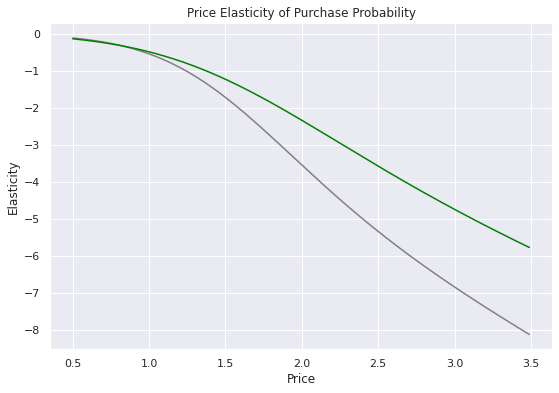

In [27]:
# We plot the elasticities of the average customer and the career-focused segment side by side. 
# The career-focused segment is displayed in green. The same color we used during the descriptive analysis.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

### $\color{red}{\text{Segment 2 - Fewer-Opportunities}}$

In [28]:
# Select only customers from segment 2, the fewer-opportunities.
df_pa_segment_2 = df_pa[df_pa['Segment'] == 2]

In [29]:
# Logistic regression model
Y = df_pa_segment_2['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_2['Price_1'] + 
                   df_pa_segment_2['Price_2'] + 
                   df_pa_segment_2['Price_3'] + 
                   df_pa_segment_2['Price_4'] + 
                   df_pa_segment_2['Price_5']) / 5

model_incidence_segment2 = LogisticRegression(solver = 'sag')
model_incidence_segment2.fit(X, Y)

# Calculate price elasticities
model_incidence_segment2.coef_
Y_segment_2 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment2 = Y_segment_2[:][: , 1]
pe_segment2 = model_incidence_segment2.coef_[:,0] * price_range * ( 1- purchase_pr_segment2)

### Results

In [30]:
df_price_elasticities['PE_Segment_2'] = pe_segment2

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

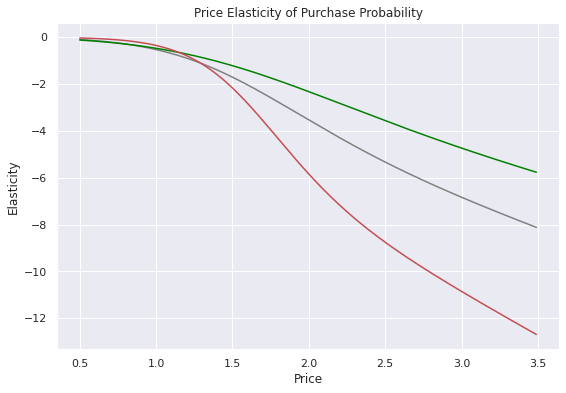

In [31]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment2, color = 'r')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

## ${\textbf{Homework}}$

### $\color{blue}{\text{Segment 0 - Standard}}$

In [32]:
# Select only customers from segment 0, the standard segment.
df_pa_segment_0 = df_pa[df_pa['Segment'] == 0]
# Prepare dependant and independant variables.
Y = df_pa_segment_0['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_0['Price_1'] + 
                   df_pa_segment_0['Price_2'] + 
                   df_pa_segment_0['Price_3'] + 
                   df_pa_segment_0['Price_4'] + 
                   df_pa_segment_0['Price_5']) / 5
# Logistic regression model
model_incidence_segment0 = LogisticRegression(solver = 'sag')
model_incidence_segment0.fit(X, Y)

model_incidence_segment0.coef_
Y_segment_0 = model_incidence_segment0.predict_proba(df_price_range)
purchase_pr_segment0 = Y_segment_0[:][: , 1]
pe_segment0 = model_incidence_segment0.coef_[:,0] * price_range *( 1- purchase_pr_segment0)
df_price_elasticities.insert(2, column = 'PE_Segment_0', value = pe_segment0)

### $\color{orange}{\text{Segment 3 - Well-Off}}$

In [33]:
# Select only customers from segment 3 
df_pa_segment_3 = df_pa[df_pa['Segment'] == 3]
# Prepare dependant and independant variables.
Y = df_pa_segment_3['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_3['Price_1'] + 
                   df_pa_segment_3['Price_2'] + 
                   df_pa_segment_3['Price_3'] + 
                   df_pa_segment_3['Price_4'] + 
                   df_pa_segment_3['Price_5']) / 5
# Logistic regression model
model_incidence_segment3 = LogisticRegression(solver = 'sag')
model_incidence_segment3.fit(X, Y)

model_incidence_segment3.coef_
Y_segment_3 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment3 = Y_segment_3[:][: , 1]
pe_segment3 = model_incidence_segment3.coef_[:,0] * price_range *( 1- purchase_pr_segment3)
df_price_elasticities['PE_Segment_3'] = pe_segment3
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3
0,0.50,-0.096468,-0.211217,-0.119178,-0.030881,-0.010572
1,0.51,-0.100539,-0.217789,-0.123364,-0.032646,-0.011176
2,0.52,-0.104737,-0.224468,-0.127644,-0.034498,-0.011810
3,0.53,-0.109066,-0.231255,-0.132018,-0.036440,-0.012475
4,0.54,-0.113528,-0.238152,-0.136489,-0.038476,-0.013172
5,0.55,-0.118127,-0.245159,-0.141057,-0.040612,-0.013903
6,0.56,-0.122865,-0.252276,-0.145725,-0.042851,-0.014669
7,0.57,-0.127747,-0.259505,-0.150494,-0.045198,-0.015473
8,0.58,-0.132776,-0.266846,-0.155364,-0.047657,-0.016315
9,0.59,-0.137955,-0.274301,-0.160339,-0.050234,-0.017197


### ${\textbf{Results}}$

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

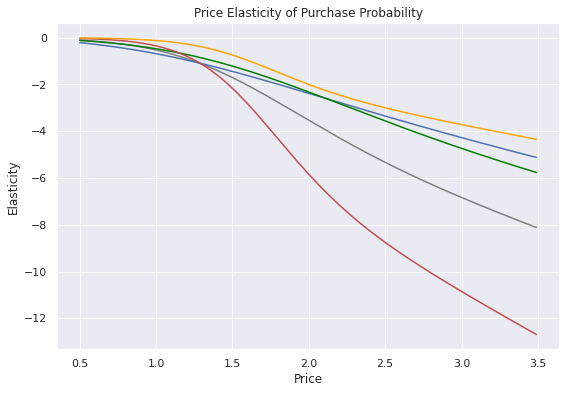

In [34]:
# We display all elasticities of purchase probability on the same plot. 
# We observe that the Career-focused segment are the least elastic when compared to the rest. 
# So, their purchase probability elasticity is not as affected by price.
# The price elasticities for the Standard segment seem to differ across price range. This may be due to the fact that
# the standard segment is least homogenous, which we discovered during our descriptive analysis. 
# It may be that the customers in this segment have different shopping habbits, which is why their 
# customers start with being more elastic than average but then shift to being more inelastic than the average customer
# and indeed the Career-focused segment.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment0, color = 'b')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment2, color = 'r')
plt.plot(price_range, pe_segment3, color = 'orange')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

## Purchase Probability with Promotion Feature

### Data Preparation

In [35]:
Y = df_pa['Incidence']

In [36]:
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] + 
                   df_pa['Price_2'] + 
                   df_pa['Price_3'] + 
                   df_pa['Price_4'] + 
                   df_pa['Price_5']) / 5

In [37]:
# We include a second promotion feature. We'd like to examine the effects of promotions on purchase probability.
# We calculate the average promotion rate across the five brands. We add the mean price for the brands.
X['Mean_Promotion'] = (df_pa['Promotion_1'] +
                       df_pa['Promotion_2'] +
                       df_pa['Promotion_3'] +
                       df_pa['Promotion_4'] +
                       df_pa['Promotion_5'] ) / 5
X.head()

,Mean_Price,Mean_Promotion
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0
3,2.028,0.0
4,2.030,0.0


## Model Estimation

In [38]:
# The coefficient for promotion is positive. 
# Therefore, there is a positive relationship between promotion and purchase probability.
model_incidence_promotion = LogisticRegression(solver = 'sag')
model_incidence_promotion.fit(X, Y)
model_incidence_promotion.coef_

array([[-1.49389989,  0.56157091]])

## Price Elasticity with Promotion

In [39]:
# We create a data frame on which our model will predict. We need to include A price and promotion feature.
# First, we'll include the price range as the price feature. Next, we'll include the promotion feature.
df_price_elasticity_promotion = pd.DataFrame(price_range)
df_price_elasticity_promotion = df_price_elasticity_promotion.rename(columns = {0: "Price_Range"})

In [40]:
# We'll calculate price elasticities of purchase probability when we assume there is a promotion across at each price points.
df_price_elasticity_promotion['Promotion'] = 1

In [41]:
# Purchase Probability with Promotion Model Prediction
Y_promotion = model_incidence_promotion.predict_proba(df_price_elasticity_promotion)

In [42]:
promo = Y_promotion[:, 1]
price_elasticity_promo = (model_incidence_promotion.coef_[:, 0] * price_range) * (1 - promo)

In [43]:
# Update master data to include elasticities of purchase probability with promotion feature
df_price_elasticities['Elasticity_Promotion_1'] = price_elasticity_promo
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1
0,0.50,-0.096468,-0.211217,-0.119178,-0.030881,-0.010572,-0.125720
1,0.51,-0.100539,-0.217789,-0.123364,-0.032646,-0.011176,-0.129835
2,0.52,-0.104737,-0.224468,-0.127644,-0.034498,-0.011810,-0.134030
3,0.53,-0.109066,-0.231255,-0.132018,-0.036440,-0.012475,-0.138304
4,0.54,-0.113528,-0.238152,-0.136489,-0.038476,-0.013172,-0.142660
5,0.55,-0.118127,-0.245159,-0.141057,-0.040612,-0.013903,-0.147097
6,0.56,-0.122865,-0.252276,-0.145725,-0.042851,-0.014669,-0.151617
7,0.57,-0.127747,-0.259505,-0.150494,-0.045198,-0.015473,-0.156221
8,0.58,-0.132776,-0.266846,-0.155364,-0.047657,-0.016315,-0.160910
9,0.59,-0.137955,-0.274301,-0.160339,-0.050234,-0.017197,-0.165685


## Price Elasticity without Promotion

In [44]:
df_price_elasticity_promotion_no = pd.DataFrame(price_range)
df_price_elasticity_promotion_no = df_price_elasticity_promotion_no.rename(columns = {0: "Price_Range"})

In [45]:
# Promotion feature -No Promotion.
# We assume there aren't any promotional activities on any of the price points.
# We examine the elasticity of purchase probability when there isn't promotion.
df_price_elasticity_promotion_no['Promotion'] = 0

In [46]:
#Purchase Probability without Promotion Model Prediction
Y_no_promo = model_incidence_promotion.predict_proba(df_price_elasticity_promotion_no)

In [47]:
no_promo = Y_no_promo[: , 1]

In [48]:
price_elasticity_no_promo = model_incidence_promotion.coef_[:, 0] * price_range *(1- no_promo)

In [49]:
# Update master data frame to include purchase probability elasticities without promotion.
# We can now see the values with and without promotion and compare them for each price point in our price range.
df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_no_promo

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability with and without Promotion')

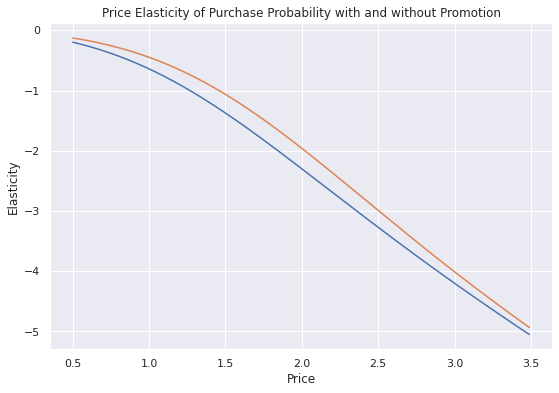

In [50]:
# Plot purchase elasticities with and without promotion side by side for comprarisson.
# Here we observe that the purchase probability elasticity of the customer is less elastic when there is promotion.
# This is an important insight for marketers, as according to our model people are more likely to buy a product if there is
# some promotional activity rather than purchase a product with the same price, when it isn't on promotion. 
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_no_promo)
plt.plot(price_range, price_elasticity_promo)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability with and without Promotion')

## ${\textbf{Brand Choice}}$

### Data Preparation

In [51]:
# Here we are interested in determining the brand choice of the customer. 
# Hence, we filter our data, to include only purchase occasion, when a purchase has occured. 
brand_choice = df_pa[df_pa['Incidence'] == 1]

In [52]:
# We cap the maximum displayed rows in a table, to make computation more efficient and easier readability.
pd.options.display.max_rows = 100
brand_choice

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,2.09,2.67,0,0,0,0,0,0,0,47,1,110866,1,0,2,0,0,1,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,2.12,2.62,1,0,0,0,1,0,0,47,1,110866,1,0,2,0,0,1,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,1.97,2.67,0,0,0,1,0,0,0,47,1,110866,1,0,2,0,0,1,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,2.16,2.68,1,1,0,0,0,0,0,47,1,110866,1,0,2,0,0,1,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,1.89,2.37,1,0,0,1,1,0,0,47,1,110866,1,0,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58621,200000500,296,1,2,6,0,0,1.48,1.89,2.01,2.18,2.69,0,0,0,0,0,0,0,42,1,120946,1,0,2,0,0,1,0
58648,200000500,460,1,1,12,0,0,1.35,1.57,2.02,2.21,2.70,1,1,0,0,0,0,0,42,1,120946,1,0,2,0,0,1,0
58674,200000500,641,1,2,7,0,0,1.50,1.85,2.06,2.24,2.79,1,1,0,0,0,0,0,42,1,120946,1,0,2,0,0,1,0
58687,200000500,697,1,2,6,0,0,1.42,1.51,1.97,2.24,2.78,0,0,0,0,0,0,0,42,1,120946,1,0,2,0,0,1,0


In [53]:
# Our model will predict the brand.
Y = brand_choice['Brand']

In [54]:
# Here we decide which features to include for prediction.
brand_choice.columns.values

array(['ID', 'Day', 'Incidence', 'Brand', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3',
       'Promotion_4', 'Promotion_5', 'Sex', 'Marital status', 'Age',
       'Education', 'Income', 'Occupation', 'Settlement size', 'Segment',
       'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3'], dtype=object)

In [55]:
# We predict based on the prices for the five brands.
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
X = brand_choice[features]

In [56]:
# Brand Choice Model fit.
model_brand_choice = LogisticRegression(solver = 'sag', multi_class = 'multinomial')
model_brand_choice.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
# Here are the coeffictients for the model. We have five brands and five features for the price. 
# Therefore, this output is somewhat difficult to read.
model_brand_choice.coef_

array([[-3.9159301 ,  0.65847013,  2.41783179,  0.70410174, -0.20207148],
       [ 1.27461736, -1.87985357, -0.21263176, -0.20633704,  0.58787576],
       [ 1.62414491,  0.56209323,  0.50073051,  1.03947898,  0.45273333],
       [ 0.57454238,  0.39559   , -1.40059356, -1.2462399 ,  0.24935631],
       [ 0.44262546,  0.26370022, -1.30533697, -0.29100378, -1.08789391]])

In [58]:
# We create a pandas data frame, which contains to coefficients.
bc_coef = pd.DataFrame(model_brand_choice.coef_)
bc_coef

,0,1,2,3,4
0,-3.915930,0.658470,2.417832,0.704102,-0.202071
1,1.274617,-1.879854,-0.212632,-0.206337,0.587876
2,1.624145,0.562093,0.500731,1.039479,0.452733
3,0.574542,0.395590,-1.400594,-1.246240,0.249356
4,0.442625,0.263700,-1.305337,-0.291004,-1.087894


In [59]:
# We make some transformations on the coefficients data frame to increase readability.
# We transpose the data frame, to keep with the conventional representation of results.
# We add labels for the columns and the index, which represent the coefficients of the brands and prices, respectively. 
bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_))
coefficients = ['Coef_Brand_1', 'Coef_Brand_2', 'Coef_Brand_3', 'Coef_Brand_4', 'Coef_Brand_5']
bc_coef.columns = [coefficients]
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.92,1.27,1.62,0.57,0.44
Price_2,0.66,-1.88,0.56,0.40,0.26
Price_3,2.42,-0.21,0.50,-1.40,-1.31
Price_4,0.70,-0.21,1.04,-1.25,-0.29
Price_5,-0.20,0.59,0.45,0.25,-1.09


## Own Price Elasticity Brand 5

In [60]:
# We want to calculate price elasticity of brand choice.
# Here we create a data frame with price columns, which our model will use to predict the brand choice probabilities.
df_own_brand_5 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_5'] = price_range
df_own_brand_5

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,2.159658,0.50
1,1.384559,1.764717,2.006694,2.159658,0.51
2,1.384559,1.764717,2.006694,2.159658,0.52
3,1.384559,1.764717,2.006694,2.159658,0.53
4,1.384559,1.764717,2.006694,2.159658,0.54
...,...,...,...,...,...
295,1.384559,1.764717,2.006694,2.159658,3.45
296,1.384559,1.764717,2.006694,2.159658,3.46
297,1.384559,1.764717,2.006694,2.159658,3.47
298,1.384559,1.764717,2.006694,2.159658,3.48


In [61]:
# Brand Choice Model prediction.
predict_brand_5 = model_brand_choice.predict_proba(df_own_brand_5)

In [62]:
# Our model returns the probabilities of choosing each of the 5 brands. 
# Since, we are interested in the probability for the fifth brand we need to obtain the last column located on position 4,
# as we're starting to count from 0.
pr_own_brand_5 = predict_brand_5[: ][:, 4]

In [63]:
# We're interested in choosing brand 5. 
# Therefore, the beta coefficient we require is that of the brand 5 coefficient and price 5.
beta5 = bc_coef.iloc[4, 4]
beta5

-1.09

In [64]:
# Calculating price elasticities for brand choice without promotion. 
own_price_elasticity_brand_5 = beta5 * price_range * (1 - pr_own_brand_5)

In [65]:
# Adding the price elasticities to our master data frame. 
df_price_elasticities['Brand_5'] = own_price_elasticity_brand_5
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5
0,0.50,-0.096468,-0.211217,-0.119178,-0.030881,-0.010572,-0.125720,-0.195632,-0.049055
1,0.51,-0.100539,-0.217789,-0.123364,-0.032646,-0.011176,-0.129835,-0.201753,-0.050616
2,0.52,-0.104737,-0.224468,-0.127644,-0.034498,-0.011810,-0.134030,-0.207976,-0.052206
3,0.53,-0.109066,-0.231255,-0.132018,-0.036440,-0.012475,-0.138304,-0.214303,-0.053826
4,0.54,-0.113528,-0.238152,-0.136489,-0.038476,-0.013172,-0.142660,-0.220733,-0.055476
5,0.55,-0.118127,-0.245159,-0.141057,-0.040612,-0.013903,-0.147097,-0.227269,-0.057158
6,0.56,-0.122865,-0.252276,-0.145725,-0.042851,-0.014669,-0.151617,-0.233910,-0.058870
7,0.57,-0.127747,-0.259505,-0.150494,-0.045198,-0.015473,-0.156221,-0.240658,-0.060614
8,0.58,-0.132776,-0.266846,-0.155364,-0.047657,-0.016315,-0.160910,-0.247513,-0.062390
9,0.59,-0.137955,-0.274301,-0.160339,-0.050234,-0.017197,-0.165685,-0.254475,-0.064199


Text(0.5, 1.0, 'Own Price Elasticity of Purchase Probability for Brand 5')

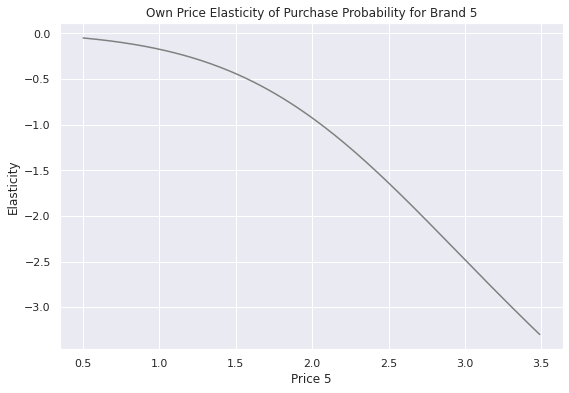

In [66]:
# Plot elasticities of purchase probability for brand 5.
plt.figure(figsize = (9, 6))
plt.plot(price_range, own_price_elasticity_brand_5, color = 'grey')
plt.xlabel('Price 5')
plt.ylabel('Elasticity')
plt.title('Own Price Elasticity of Purchase Probability for Brand 5')

## Cross Price Elasticity Brand 5, Cross Brand 4

In [67]:
# We want to examine the effect of the changes in price of a competitor brand.
# As we've discussed in the lecture, the brand which comes closest to our own brand is brand 4. 
# Therefore, we need to examine changes in the price of this brand.
# Keep in mind, we could examine the cross price elasticities for any of the remaining brands, 
# we just need to update this data frame accordingly to contain the respective brand.
df_brand5_cross_brand4 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4['Price_1'] = brand_choice['Price_1'].mean()
df_brand5_cross_brand4['Price_2'] = brand_choice['Price_2'].mean()
df_brand5_cross_brand4['Price_3'] = brand_choice['Price_3'].mean()
df_brand5_cross_brand4['Price_4'] = price_range
df_brand5_cross_brand4['Price_5'] = brand_choice['Price_5'].mean()

In [68]:
df_brand5_cross_brand4.head()

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,0.50,2.654296
1,1.384559,1.764717,2.006694,0.51,2.654296
2,1.384559,1.764717,2.006694,0.52,2.654296
3,1.384559,1.764717,2.006694,0.53,2.654296
4,1.384559,1.764717,2.006694,0.54,2.654296


In [69]:
predict_brand5_cross_brand4 = model_brand_choice.predict_proba(df_brand5_cross_brand4)

In [70]:
# As now we're interested in what the probability of choosing the competitor brand is, 
# we need to select the purchase probability for brand 4, contained in the 4th column with index 3. 
pr_brand_4 = predict_brand5_cross_brand4[:][:, 3]

In [71]:
beta5

-1.09

In [72]:
# In order to calculate the cross brand price elasticity, we need to use the new formula we introduced in the lecture.
# The elasticity is equal to negative the price coefficient of the own brand multiplied by the price of the cross brand,
# further multiplied by the probability for choosing the cross brand.
brand5_cross_brand4_price_elasticity = -beta5 * price_range * pr_brand_4

In [73]:
# Update price elasticities data frame to include the cross price elasticities for brand 5 with respect to brand 4.
df_price_elasticities['Brand_5_Cross_Brand_4'] = brand5_cross_brand4_price_elasticity
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4
0,0.50,-0.096468,-0.211217,-0.119178,-0.030881,-0.010572,-0.125720,-0.195632,-0.049055,0.332011
1,0.51,-0.100539,-0.217789,-0.123364,-0.032646,-0.011176,-0.129835,-0.201753,-0.050616,0.337287
2,0.52,-0.104737,-0.224468,-0.127644,-0.034498,-0.011810,-0.134030,-0.207976,-0.052206,0.342506
3,0.53,-0.109066,-0.231255,-0.132018,-0.036440,-0.012475,-0.138304,-0.214303,-0.053826,0.347668
4,0.54,-0.113528,-0.238152,-0.136489,-0.038476,-0.013172,-0.142660,-0.220733,-0.055476,0.352773
5,0.55,-0.118127,-0.245159,-0.141057,-0.040612,-0.013903,-0.147097,-0.227269,-0.057158,0.357820
6,0.56,-0.122865,-0.252276,-0.145725,-0.042851,-0.014669,-0.151617,-0.233910,-0.058870,0.362809
7,0.57,-0.127747,-0.259505,-0.150494,-0.045198,-0.015473,-0.156221,-0.240658,-0.060614,0.367740
8,0.58,-0.132776,-0.266846,-0.155364,-0.047657,-0.016315,-0.160910,-0.247513,-0.062390,0.372614
9,0.59,-0.137955,-0.274301,-0.160339,-0.050234,-0.017197,-0.165685,-0.254475,-0.064199,0.377429


Text(0.5, 1.0, 'Cross Price Elasticity of Brand 5 wrt Brand 4')

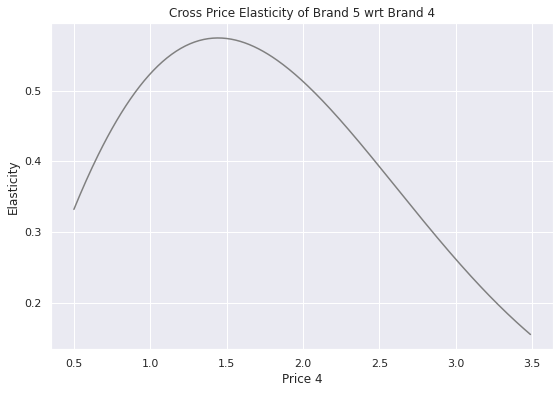

In [74]:
# Here we examine the cross price elasticity of purchase probability for brand 5 with respect to brand 4.
# We observe they are positive. As the price of the competitor brand increases, 
# so does the probability for purchasing our own brand.
# Even though the elasticity starts to decrease from the 1.45 mark, it is still positive, 
# signalling that the increase in purchase probability for the own brand happens more slowly.
plt.figure(figsize = (9, 6))
plt.plot(price_range, brand5_cross_brand4_price_elasticity, color = 'grey')
plt.xlabel('Price 4')
plt.ylabel('Elasticity')
plt.title('Cross Price Elasticity of Brand 5 wrt Brand 4')

## Own and Cross-Price Elasticity by Segment

### $\color{orange}{\text{Well-Off}}$

In [75]:
# We are interested in analysing the purchase probability for choosing brand 5 by segments.
# We filter our data to contain only purchase incidences of the third segment - Well-off.
brand_choice_s3 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s3 = brand_choice_s3[brand_choice_s3['Segment'] == 3]

pd.options.display.max_rows = 100
brand_choice_s3

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
101,200000002,6,1,4,1,0,0,1.59,1.87,2.01,2.09,2.66,0,0,0,0,0,1,1,52,2,159052,2,1,3,0,0,0,1
115,200000002,100,1,4,2,0,0,1.47,1.90,1.95,2.12,2.67,0,0,0,1,0,1,1,52,2,159052,2,1,3,0,0,0,1
138,200000002,283,1,4,3,0,0,1.37,1.89,2.00,2.14,2.64,0,0,0,0,0,1,1,52,2,159052,2,1,3,0,0,0,1
141,200000002,307,1,4,1,0,0,1.34,1.89,2.01,2.03,2.68,1,0,0,1,0,1,1,52,2,159052,2,1,3,0,0,0,1
153,200000002,422,1,4,1,0,0,1.34,1.89,2.02,2.21,2.65,0,0,0,1,0,1,1,52,2,159052,2,1,3,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57346,200000489,687,1,4,1,4,1,1.50,1.87,2.06,2.24,2.78,0,0,0,0,0,1,1,44,2,193816,2,1,3,0,0,0,1
57347,200000489,693,1,4,2,4,1,1.42,1.51,2.02,2.24,2.77,0,1,0,0,0,1,1,44,2,193816,2,1,3,0,0,0,1
57348,200000489,701,1,4,3,4,1,1.42,1.85,1.99,2.24,2.76,0,0,1,0,0,1,1,44,2,193816,2,1,3,0,0,0,1
57350,200000489,715,1,4,2,0,0,1.50,1.80,2.09,2.24,2.79,0,0,0,0,0,1,1,44,2,193816,2,1,3,0,0,0,1


In [76]:
# Brand Choice Model estimation.
Y = brand_choice_s3['Brand']
brand_choice_s3 = pd.get_dummies(brand_choice_s3, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s3[features]
model_brand_choice_s3 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s3.fit(X, Y)

# Coefficients table for segment 3
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s3.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-2.15,1.33,0.82,0.12,-0.11
Price_2,-0.96,-1.38,1.29,0.78,0.27
Price_3,2.01,-1.65,-0.49,0.03,0.11
Price_4,2.52,0.96,-0.25,-1.90,-1.33
Price_5,-0.99,-0.30,1.17,0.56,-0.44


### $\color{orange}{\text{Own-Brand Price Elasticity}}$

In [77]:
# Calculating own-brand price elasticity for brand 5 and the Well-off segment.
df_own_brand_5_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_own_brand_5_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_own_brand_5_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_own_brand_5_s3['Price_4'] = brand_choice_s3['Price_4'].mean()
df_own_brand_5_s3['Price_5'] = price_range

predict_own_brand_5_s3 = model_brand_choice_s3.predict_proba(df_own_brand_5_s3)
pr_own_brand_5_s3 = predict_own_brand_5_s3[: ][: , 4]

own_price_elasticity_brand_5_s3 =  beta5 * price_range * (1 - pr_own_brand_5_s3)
df_price_elasticities['Brand 5 S3'] = own_price_elasticity_brand_5_s3

### $\color{orange}{\text{Cross-Brand Price Elasticity}}$

In [78]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Well-off segment.
df_brand5_cross_brand4_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_brand5_cross_brand4_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_brand5_cross_brand4_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_brand5_cross_brand4_s3['Price_4'] = price_range
df_brand5_cross_brand4_s3['Price_5'] = brand_choice_s3['Price_5'].mean()

predict_brand5_cross_brand4_s3 = model_brand_choice_s3.predict_proba(df_brand5_cross_brand4_s3)
pr_cross_brand_5_s3 = predict_brand5_cross_brand4_s3[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_s3 = -beta5 * price_range * pr_cross_brand_5_s3
df_price_elasticities['Brand_5_Cross_Brand_4_S3'] = brand5_cross_brand4_price_elasticity_s3
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096468,-0.211217,-0.119178,-0.030881,-0.010572,-0.125720,-0.195632,-0.049055,0.332011,-0.297312,0.482421
1,0.51,-0.100539,-0.217789,-0.123364,-0.032646,-0.011176,-0.129835,-0.201753,-0.050616,0.337287,-0.303358,0.491726
2,0.52,-0.104737,-0.224468,-0.127644,-0.034498,-0.011810,-0.134030,-0.207976,-0.052206,0.342506,-0.309414,0.501016
3,0.53,-0.109066,-0.231255,-0.132018,-0.036440,-0.012475,-0.138304,-0.214303,-0.053826,0.347668,-0.315481,0.510290
4,0.54,-0.113528,-0.238152,-0.136489,-0.038476,-0.013172,-0.142660,-0.220733,-0.055476,0.352773,-0.321559,0.519548
5,0.55,-0.118127,-0.245159,-0.141057,-0.040612,-0.013903,-0.147097,-0.227269,-0.057158,0.357820,-0.327649,0.528790
6,0.56,-0.122865,-0.252276,-0.145725,-0.042851,-0.014669,-0.151617,-0.233910,-0.058870,0.362809,-0.333750,0.538016
7,0.57,-0.127747,-0.259505,-0.150494,-0.045198,-0.015473,-0.156221,-0.240658,-0.060614,0.367740,-0.339864,0.547226
8,0.58,-0.132776,-0.266846,-0.155364,-0.047657,-0.016315,-0.160910,-0.247513,-0.062390,0.372614,-0.345990,0.556420
9,0.59,-0.137955,-0.274301,-0.160339,-0.050234,-0.017197,-0.165685,-0.254475,-0.064199,0.377429,-0.352129,0.565597


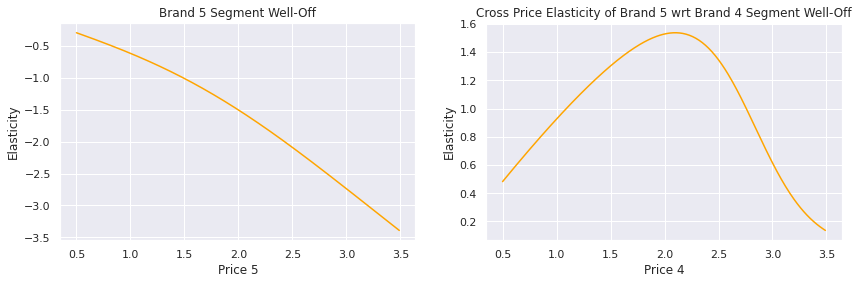

In [79]:
# Using a figure with axes we plot the own brand and cross-brand price elasticities for brand 5 cross brand 4 side by side.
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_s3, color = 'orange')
axs[0].set_title('Brand 5 Segment Well-Off')
axs[0].set_xlabel('Price 5')

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, color = 'orange')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Well-Off')
axs[1].set_xlabel('Price 4')

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')

### $\color{blue}{\text{Standard}}$

In [80]:
# Here we are interesting in analysing the brand choice probability of the Standard segment.
# We filter our data, by selecting only purchases from segment 0.
brand_choice_s0 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s0 = brand_choice_s0[brand_choice_s0['Segment'] == 0]
brand_choice_s0.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
2398,200000024,44,1,2,2,0,0,1.35,1.58,1.97,2.09,2.67,1,1,1,0,0,1,1,32,1,88428,0,0,0,1,0,0,0
2403,200000024,98,1,2,2,0,0,1.47,1.90,1.95,2.12,2.67,0,0,0,0,0,1,1,32,1,88428,0,0,0,1,0,0,0
2408,200000024,143,1,2,3,0,0,1.21,1.35,1.99,2.16,2.67,1,1,0,0,0,1,1,32,1,88428,0,0,0,1,0,0,0
2410,200000024,162,1,2,5,0,0,1.39,1.90,1.94,2.16,2.49,1,0,0,0,0,1,1,32,1,88428,0,0,0,1,0,0,0
2417,200000024,217,1,5,1,0,0,1.34,1.89,1.99,2.13,2.67,0,0,0,0,0,1,1,32,1,88428,0,0,0,1,0,0,0


In [81]:
# Brand Choice Model estimation.
Y = brand_choice_s0['Brand']
brand_choice_s0 = pd.get_dummies(brand_choice_s0, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s0[features]
model_brand_choice_s0 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 200)
model_brand_choice_s0.fit(X, Y)

# Coefficients table segment 0.
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s0.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{blue}{\text{Own-Brand Price Elasticity}}$

In [82]:
# Calculating own-brand price elasticity for brand 5 and the Standard segment.
df_own_brand_5_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_own_brand_5_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_own_brand_5_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_own_brand_5_s0['Price_4'] = brand_choice_s0['Price_4'].mean()
df_own_brand_5_s0['Price_5'] = price_range

predict_own_brand_5_s0 = model_brand_choice_s0.predict_proba(df_own_brand_5_s0)
pr_own_brand_5_s0 = predict_own_brand_5_s0[: ][: , 4]

# Compute price elasticities and update master data frame.
# We'd like to include the elasticities for the segments in order from 0 to three, which is why we use insert() on position 10.
own_price_elasticity_brand_5_s0 =  beta5 * price_range * (1 - pr_own_brand_5_s0)
df_price_elasticities.insert(10, column = 'Brand 5 S0', value = own_price_elasticity_brand_5_s0)

### $\color{blue}{\text{Cross-Brand Price Elasticity}}$

In [83]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Standard segment.
df_brand5_cross_brand4_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_brand5_cross_brand4_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_brand5_cross_brand4_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_brand5_cross_brand4_s0['Price_4'] = price_range
df_brand5_cross_brand4_s0['Price_5'] = brand_choice_s0['Price_5'].mean()

predict_brand5_cross_brand4_s0 = model_brand_choice_s0.predict_proba(df_brand5_cross_brand4_s0)
pr_cross_brand_5_s0 = predict_brand5_cross_brand4_s0[: ][: , 3]

# Compute price elasticities and update master data frame.
# We need to use insert() on position 11, to save the price elasticities in the correct order.
brand5_cross_brand4_price_elasticity_s0 = -beta5 * price_range * pr_cross_brand_5_s0
df_price_elasticities.insert(11, column = 'Brand_5_Cross_Brand_4_S0', value = brand5_cross_brand4_price_elasticity_s0)

### $\color{green}{\text{Career-Focused}}$

In [84]:
# Filter data by the Career-focused segment, which is the first segment.
brand_choice_s1 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s1 = brand_choice_s1[brand_choice_s1['Segment'] == 1]

In [85]:
# Brand Choice Model estimation.
Y = brand_choice_s1['Brand']
brand_choice_s1 = pd.get_dummies(brand_choice_s1, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s1[features]
model_brand_choice_s1 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s1.fit(X, Y)

# Coefficients table segment 1
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s1.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{green}{\text{Own-Brand Price Elasticity}}$

In [86]:
# Calculating own-brand price elasticity for brand 5 and the Career-focused segment.
df_own_brand_5_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_own_brand_5_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_own_brand_5_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_own_brand_5_s1['Price_4'] = brand_choice_s1['Price_4'].mean()
df_own_brand_5_s1['Price_5'] = price_range

predict_own_brand_5_s1 = model_brand_choice_s1.predict_proba(df_own_brand_5_s1)
pr_own_brand_5_s1 = predict_own_brand_5_s1[: ][: , 4]

#compute price elasticities and update data frame
own_price_elasticity_brand_5_s1 =  beta5 * price_range * (1 - pr_own_brand_5_s1)
df_price_elasticities.insert(12, column = 'Brand 5 S1', value = own_price_elasticity_brand_5_s1)

### $\color{green}{\text{Cross-Brand Price Elasticity}}$

In [87]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Career-focused segment.
df_brand5_cross_brand4_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_brand5_cross_brand4_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_brand5_cross_brand4_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_brand5_cross_brand4_s1['Price_4'] = price_range
df_brand5_cross_brand4_s1['Price_5'] = brand_choice_s1['Price_5'].mean()

predict_brand5_cross_brand4_s1 = model_brand_choice_s1.predict_proba(df_brand5_cross_brand4_s1)
pr_cross_brand_5_s1 = predict_brand5_cross_brand4_s1[: ][: , 3]

brand5_cross_brand4_price_elasticity_s1 = -beta5 * price_range * pr_cross_brand_5_s1
df_price_elasticities.insert(13, column = 'Brand_5_Cross_Brand_4_S1', value = brand5_cross_brand4_price_elasticity_s1)

### $\color{red}{\text{Fewer-Opportunities}}$

In [88]:
# Filter data, select only purchases from segment 2, which is the Fewer-Opportunities segment.
brand_choice_s2 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s2 = brand_choice_s2[brand_choice_s2['Segment'] == 2]

In [89]:
# Brand Choice Model estimation.
Y = brand_choice_s2['Brand']
brand_choice_s2 = pd.get_dummies(brand_choice_s2, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s2[features]
model_brand_choice_s2 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s2.fit(X, Y)

# Coefficients table segment 2
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s2.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{red}{\text{Own-Brand Price Elasticity}}$

In [90]:
# Calculating own-brand price elasticity for brand 5 and the Fewer-opportunities segment.
df_own_brand_5_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_own_brand_5_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_own_brand_5_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_own_brand_5_s2['Price_4'] = brand_choice_s2['Price_4'].mean()
df_own_brand_5_s2['Price_5'] = price_range

predict_own_brand_5_s2 = model_brand_choice_s2.predict_proba(df_own_brand_5_s2)
pr_own_brand_5_s2 = predict_own_brand_5_s2[: ][: , 4]

#compute price elasticities and update data frame
own_price_elasticity_brand_5_s2 =  beta5 * price_range * (1 - pr_own_brand_5_s2)
df_price_elasticities.insert(14, column = 'Brand 5 S2', value = own_price_elasticity_brand_5_s2)

### $\color{red}{\text{Cross-Brand Price Elasticity}}$

In [91]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Fewer-opportunities segment.
df_brand5_cross_brand4_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_brand5_cross_brand4_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_brand5_cross_brand4_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_brand5_cross_brand4_s2['Price_4'] = price_range
df_brand5_cross_brand4_s2['Price_5'] = brand_choice_s2['Price_5'].mean()

predict_brand5_cross_brand4_s2 = model_brand_choice_s2.predict_proba(df_brand5_cross_brand4_s2)
pr_cross_brand_5_s2 = predict_brand5_cross_brand4_s2[: ][: , 3]

brand5_cross_brand4_price_elasticity_s2 = -beta5 * price_range * pr_cross_brand_5_s2
df_price_elasticities.insert(15, column = 'Brand_5_Cross_Brand_4_S2', value = brand5_cross_brand4_price_elasticity_s2)
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096468,-0.211217,-0.119178,-0.030881,-0.010572,-0.125720,-0.195632,-0.049055,0.332011,-0.115855,0.174141,-0.043941,0.194765,-0.001036,0.181593,-0.297312,0.482421
1,0.51,-0.100539,-0.217789,-0.123364,-0.032646,-0.011176,-0.129835,-0.201753,-0.050616,0.337287,-0.118895,0.176197,-0.045028,0.197249,-0.001098,0.183890,-0.303358,0.491726
2,0.52,-0.104737,-0.224468,-0.127644,-0.034498,-0.011810,-0.134030,-0.207976,-0.052206,0.342506,-0.121969,0.178202,-0.046124,0.199682,-0.001163,0.186138,-0.309414,0.501016
3,0.53,-0.109066,-0.231255,-0.132018,-0.036440,-0.012475,-0.138304,-0.214303,-0.053826,0.347668,-0.125078,0.180156,-0.047229,0.202064,-0.001231,0.188337,-0.315481,0.510290
4,0.54,-0.113528,-0.238152,-0.136489,-0.038476,-0.013172,-0.142660,-0.220733,-0.055476,0.352773,-0.128223,0.182059,-0.048344,0.204396,-0.001303,0.190488,-0.321559,0.519548
5,0.55,-0.118127,-0.245159,-0.141057,-0.040612,-0.013903,-0.147097,-0.227269,-0.057158,0.357820,-0.131405,0.183913,-0.049469,0.206678,-0.001378,0.192591,-0.327649,0.528790
6,0.56,-0.122865,-0.252276,-0.145725,-0.042851,-0.014669,-0.151617,-0.233910,-0.058870,0.362809,-0.134622,0.185717,-0.050603,0.208911,-0.001458,0.194646,-0.333750,0.538016
7,0.57,-0.127747,-0.259505,-0.150494,-0.045198,-0.015473,-0.156221,-0.240658,-0.060614,0.367740,-0.137877,0.187471,-0.051746,0.211094,-0.001541,0.196653,-0.339864,0.547226
8,0.58,-0.132776,-0.266846,-0.155364,-0.047657,-0.016315,-0.160910,-0.247513,-0.062390,0.372614,-0.141169,0.189177,-0.052900,0.213228,-0.001629,0.198613,-0.345990,0.556420
9,0.59,-0.137955,-0.274301,-0.160339,-0.050234,-0.017197,-0.165685,-0.254475,-0.064199,0.377429,-0.144499,0.190834,-0.054063,0.215314,-0.001722,0.200525,-0.352129,0.565597


Text(0.5, 0, 'Price 4')

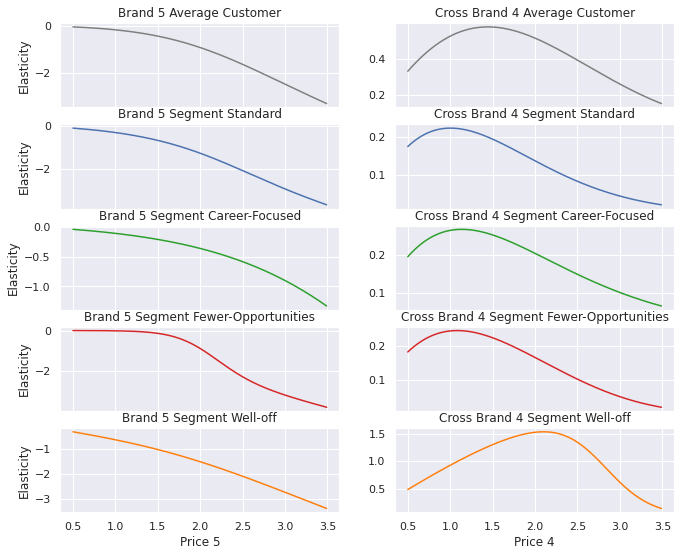

In [92]:
# We plot the own and cross brand price elasticities for the average customer and each of the four segments.
# We can observe differences and similiraties between the segments and examine their preference, when it comes to brand choice.
# The two segments, which seem to be of most interested for the marketing team of brand 5, seem to be the Career-focused
# and the Well-off. They are also the segments which purchase this brand most often. 
# The Career-focused segment is the most inelastic and they are the most loyal segment. 
# Based on our model, they do not seem to be that affected by price, therefore brand 5 could increase its price, 
# without fear of significant loss of customers from this segment. 
# The Well-off segment on the other hand, seems to be more elastic. They also purchase the competitor brand 4 most often.
# In order to target this segment, our analysis signals, that price needs to be decreased. However, keep in mind 
# that other factors aside from price might be influencing the purchase behaivour of this segment.
fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize = (11, 9), sharex = True)
ax1[0].plot(price_range, own_price_elasticity_brand_5, 'tab:grey')
ax1[0].set_title('Brand 5 Average Customer')
ax1[0].set_ylabel('Elasticity')
ax1[1].plot(price_range, brand5_cross_brand4_price_elasticity, 'tab:grey')
ax1[1].set_title('Cross Brand 4 Average Customer')


ax2[0].plot(price_range, own_price_elasticity_brand_5_s0)
ax2[0].set_title('Brand 5 Segment Standard')
ax2[0].set_ylabel('Elasticity')
ax2[1].plot(price_range, brand5_cross_brand4_price_elasticity_s0)
ax2[1].set_title('Cross Brand 4 Segment Standard')

ax3[0].plot(price_range, own_price_elasticity_brand_5_s1, 'tab:green')
ax3[0].set_title('Brand 5 Segment Career-Focused')
ax3[0].set_ylabel('Elasticity')
ax3[1].plot(price_range, brand5_cross_brand4_price_elasticity_s1, 'tab:green')
ax3[1].set_title('Cross Brand 4 Segment Career-Focused')

ax4[0].plot(price_range, own_price_elasticity_brand_5_s2, 'tab:red')
ax4[0].set_title('Brand 5 Segment Fewer-Opportunities')
ax4[0].set_ylabel('Elasticity')
ax4[1].plot(price_range, brand5_cross_brand4_price_elasticity_s2, 'tab:red')
ax4[1].set_title('Cross Brand 4 Segment Fewer-Opportunities')

ax5[0].plot(price_range, own_price_elasticity_brand_5_s3, 'tab:orange')
ax5[0].set_title('Brand 5 Segment Well-off')
ax5[0].set_xlabel('Price 5')
ax5[0].set_ylabel('Elasticity')
ax5[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, 'tab:orange')
ax5[1].set_title('Cross Brand 4 Segment Well-off')
ax5[1].set_xlabel('Price 4')